# Lagator et al. Model

In [1]:
using wgregseq, CSV, DataFrames, CairoMakie, BioSequences

wgregseq.viz.default_makie!()

palette_dict, palette = wgregseq.viz.get_colors()

2-element Vector{Any}:
 Dict("light_blue" => "#5fa6db", "light_red" => "#e89290", "primary_blue" => "#3373ba", "green" => "#488d48", "pale_red" => "#eeb3b0", "light_green" => "#99d097", "primary_green" => "#5cb75b", "light_black" => "#8c8c8c", "gold" => "#b1843e", "pale_blue" => "#8ec1e8"…)
 ["#4c4b4c", "#3373ba", "#5cb75b", "#8066ad", "#f0ad4d", "#d8534f"]

Import all expression shifts.

In [2]:
df_exshifts = CSV.read("../../figures/interactive_footprints/exshifts.csv", DataFrame);

Import the model. Choosing the extended model that was fit on all their datasets. 

In [3]:
# create random sequence
numSeqs = rand([1, 2, 3, 4], 160)

# fit the model
bricks = wgregseq.promoter_finder.predict(numSeqs)

/Users/tomroeschinger/miniconda3/envs/regseq2/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


126×5 Matrix{Float64}:
 29.1372  26.9282   17.3636   24.3219  23.7153
 30.04    19.6239   21.6855   15.4841  25.3052
 14.7232  19.2688   13.1232   18.548   15.2094
 33.2689  19.9766   28.7927   26.0103  34.2979
 33.1051  24.5777   15.5559   27.7351  27.8156
 39.4075  26.9714   22.7146   17.0559  32.098
 26.7513  26.8085   18.643    17.7493  14.9535
 37.2567  26.2403   30.5681   25.7657  27.7349
 26.7511  26.544    19.7982   27.4891  25.5496
 35.0333  25.5227   29.5861   26.2035  36.7573
 27.7188  22.5224   17.2823   24.7089  24.1892
 27.959   22.5109   21.585    19.7081  29.9975
 35.7382  23.7726   22.595    25.0323  26.0183
  ⋮                                    
 27.3022  29.3119   22.899    20.6421  29.4593
 33.7375  24.3398   30.62     27.5703  28.1763
 32.1098  28.3985   23.2713   32.9147  32.7278
 21.5975  12.0316   12.5909   10.8268  23.3331
 37.8254  28.2457   22.9504   26.8728  27.9717
 27.4102  29.0784   23.7692   21.8371  28.6224
 23.16    17.8129   23.7517   21.8057  22.736

Result should be five sequences of length 125.

In [4]:
size(bricks)

(126, 5)

Display the results of the fit.

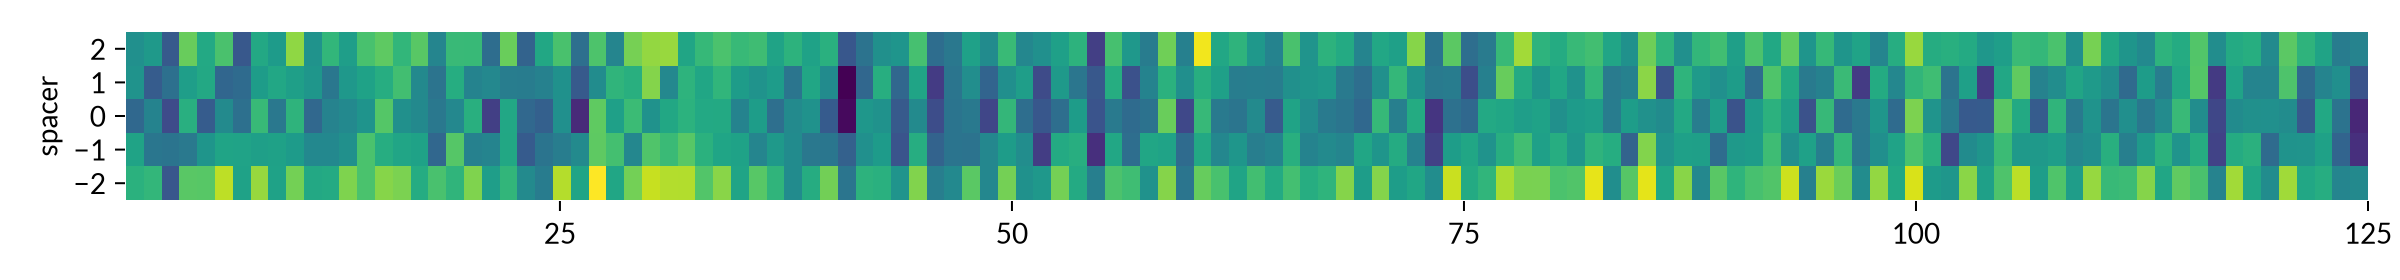

In [5]:
fig = Figure(size=(1200, 140))
ax = Axis(fig[1, 1])

heatmap!(ax, 1:125, -2:2, bricks)
ax.ylabel = "spacer"
ax.yticks = -2:2
fig

Now try with dicC promoter sequence. Try out all different possibilites for `treatas` and see if the outcome is any different.

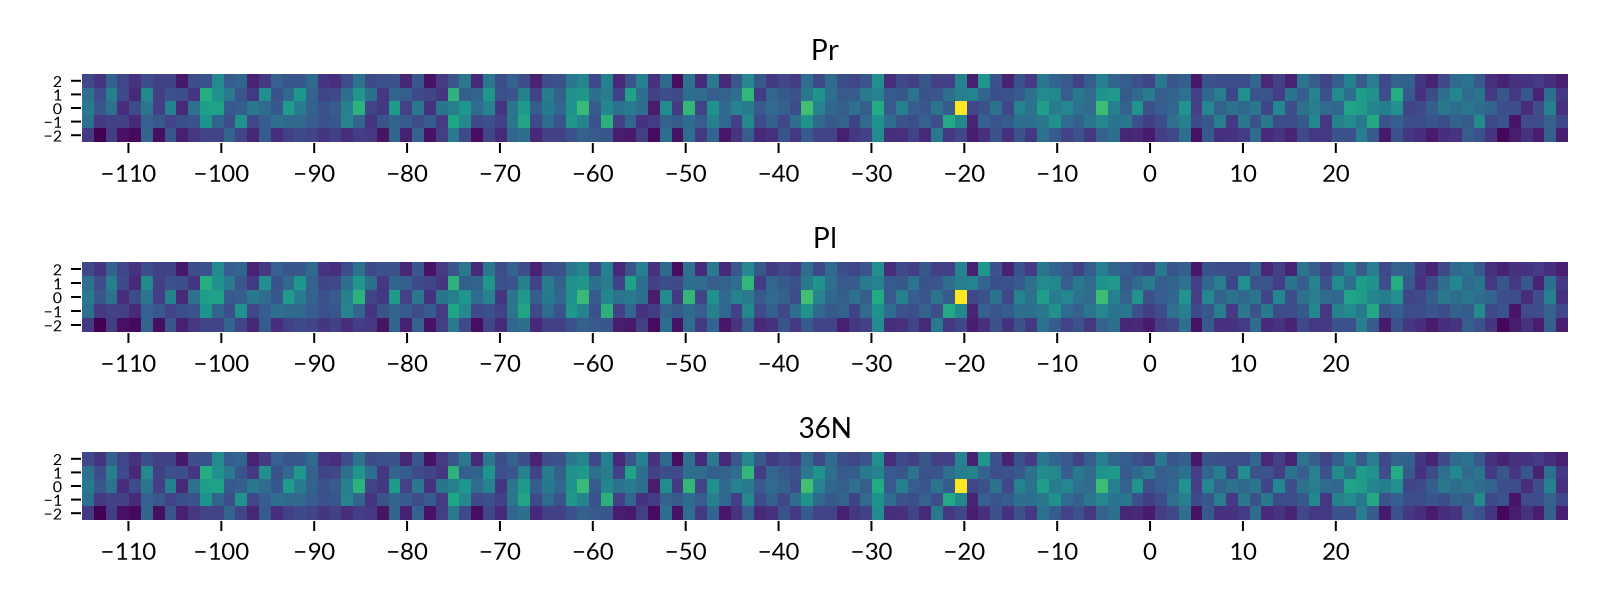

In [6]:
df = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
insertcols!(df, 4, :promoter_sequence => map(x -> x[27:186], df.sequence))
seq = df[df.promoter .== "dicCp", "promoter_sequence"][1] |> string

num_seq_dict = Dict('A' => 0, 'C' => 1, 'G' => 2, 'T' => 3)
numseq = [num_seq_dict[x] for x in collect(seq)]

fig = Figure(size=(800, 300))
ax_list = [Axis(fig[i, 1]) for i in 1:3]
for (i, model) in enumerate(["Pr", "Pl", "36N"])
    bricks = wgregseq.promoter_finder.predict(numseq, model)
    heatmap!(ax_list[i], -115:(-115+length(numseq)), -2:2, exp.(-bricks .* .04))
    ax_list[i].title = model
    ax_list[i].xticks = -110:10:20
    ax_list[i].yticks = -2:2
    ax_list[i].yticklabelsize=8
    ax_list[i].xticklabelsize=12
end

fig

Repeat the same process with the `marRp` promoter.

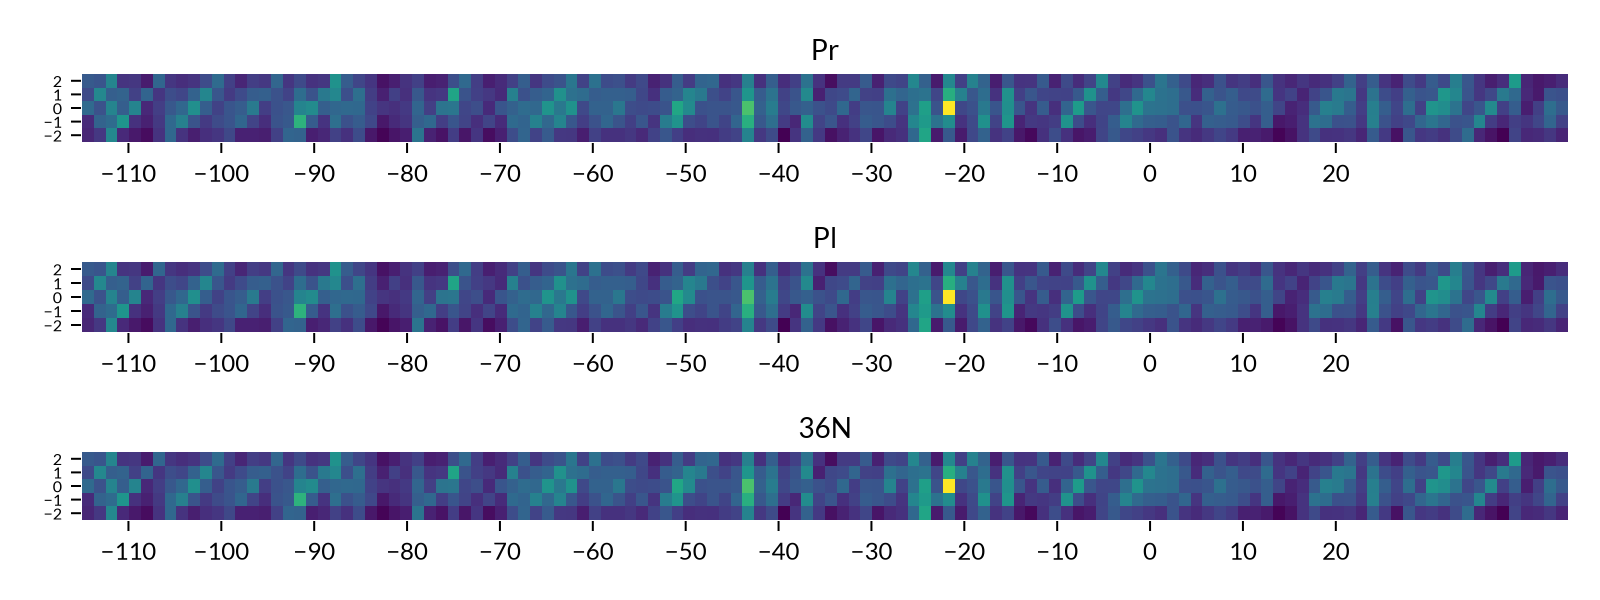

In [7]:
seq = df[df.promoter .== "marRp", "promoter_sequence"][1] |> string

num_seq_dict = Dict('A' => 0, 'C' => 1, 'G' => 2, 'T' => 3)
numseq = [num_seq_dict[x] for x in collect(seq)]

fig = Figure(size=(800, 300))
ax_list = [Axis(fig[i, 1]) for i in 1:3]
for (i, model) in enumerate(["Pr", "Pl", "36N"])
    bricks = wgregseq.promoter_finder.predict(numseq, model)
    heatmap!(ax_list[i], -115:(-115+length(numseq)), -2:2, exp.(-bricks .* .04))
    ax_list[i].title = model
    ax_list[i].xticks = -110:10:20
    ax_list[i].yticks = -2:2
    ax_list[i].yticklabelsize=8
    ax_list[i].xticklabelsize=12
end

fig

For both promoters, the start of the promoter is very clear and around the position we expect.

## Test model on each possible single mutation

Here we are going to compute every single point mutation in a promoter, and look for strong changes in the predicted free energy.

In [8]:
"""Create all possible single base pair mutations for a given sequence
    and return them as an arry of integers."""
function create_mutations(sequence, add_prim=false)
    
    
    num_seq_dict = Dict('A' => 0, 'C' => 1, 'G' => 2, 'T' => 3)
    prim = "AGTGCCATGTTATCCCTGAATCTAGT"
    if add_prim
        mutant_list = [[num_seq_dict[x] for x in collect(prim * sequence)]]
    else
        mutant_list = [[num_seq_dict[x] for x in collect(sequence)]]
    end
    mutations = [('N', 'N')]
    for i in 1:160
        base = sequence[i]
        for b in filter(x -> x != base, ['A', 'C', 'G', 'T'])
            new_sequence = collect(sequence)
            new_sequence[i] = b
            if add_prim
                push!(mutant_list, [num_seq_dict[x] for x in collect(prim * join(new_sequence))])
            else
                push!(mutant_list, [num_seq_dict[x] for x in collect(new_sequence)])
            end
            push!(mutations, ((sequence[i], b)))
        end
    end
    return mutant_list, mutations
end

create_mutations

In [9]:
"AGTGCCATGTTATCCCTGAATCTAGT" |> length

26

In [56]:
function eval_lagator_single_mutation(prom, growth_condition="Glucose", add_prim=false)
    
    # Extract sequence from dataframe
    seq = df[df.promoter .== prom, "promoter_sequence"][1] |> string
    # Create all single mutants
    mut_list, mutations = create_mutations(seq, add_prim)

    if add_prim
        offset = 115 + 26
    else
        offset = 115
    end
    
    # Apply model to each sequence, find spacer that has maximum expression
    model = "36N"
    bricks = [exp.((wgregseq.promoter_finder.predict(x, model)) .* -0.04)  for x in mut_list]
    
    max_bricks = [maximum(brick) for brick in bricks]
    max_bricks_inds = [argmax(brick)[1] for brick in bricks]
    max_bricks .-= max_bricks[1]
    max_bricks = max_bricks[2:end]

    p = wgregseq.promoter_finder.Promoter_Calculator()
    tss_list = []
    int_to_base = Dict(1 => 'A', 2 => 'C', 3 => 'G', 4 => 'T')
    for seq in mut_list
        _seq = join([int_to_base[x+1] for x in seq])
        r = p(_seq)["Forward_Predictions_per_TSS"]
        _x = [(key, r[key]["dG_total"]) for key in keys(r) |> collect]
        tss = _x[argmin([x[2] for x in _x])][1]
        push!(tss_list, tss-offset)
    end

    # Get mutations with maximum change in dG
    ordered_mutations = sortperm(max_bricks, rev=true)
    println("Top 10 single mutations: ")
    df_rank = DataFrame()
    for i in 1:length(ordered_mutations)
        ind = ordered_mutations[i]
        append!(df_rank, DataFrame(
                index=ind, 
                pos=Int(floor((ind - 1)/3)-offset), 
                wt_base=string(mutations[ind+1][1]), 
                mut_base=string(mutations[ind+1][2]), 
                brick=max_bricks[ind], 
                Lagator_tss_wt=max_bricks_inds[1]-offset,
                Lagator_tss_mut=max_bricks_inds[2:end][ind]-offset,
                lafleur_tss_wt=tss_list[1],
                lafleur_tss_mut=tss_list[ind])
        )
    end
    println("Lagator promoter: ", max_bricks_inds[1]-offset)
    println("LaFleur TSS: ", tss_list[1])
    
    sort!(df_rank, :brick, rev=true)
    #display(first(df_rank, 10))

    sub_df = df_exshifts[(df_exshifts[!, "growth_condition"] .== growth_condition) .& (df_exshifts[!, "replicate"] .== 1), :]  

    max_exshifts = DataFrame()
    for _df in groupby(sub_df, :promoter)
        append!(max_exshifts, _df[sortperm(abs.(_df[!, "expression_shift"]), rev=true), :])
    end

    prom_df = df_exshifts[(df_exshifts.growth_condition .== growth_condition) .& (df_exshifts.replicate .== 1) .& (df_exshifts.promoter .== prom), :]
    prom_df.wt_base = string.(prom_df.wt_base)
    rename!(prom_df, Dict("base" => "int_base"))
    insertcols!(prom_df, 2, :mut_base => string.([int_to_base[x] for x in prom_df.int_base]))

    println("Highest observed expression shift: ")
    #display(prom_df[sortperm(abs.(prom_df.expression_shift), rev=true), :][1:10, :])

    return innerjoin(df_rank, prom_df, on=[:pos, :wt_base, :mut_base])
end


eval_lagator_single_mutation (generic function with 3 methods)

### mglBp

Top 10 single mutations: 
Lagator promoter: 3
LaFleur TSS: 0
Highest observed expression shift: 


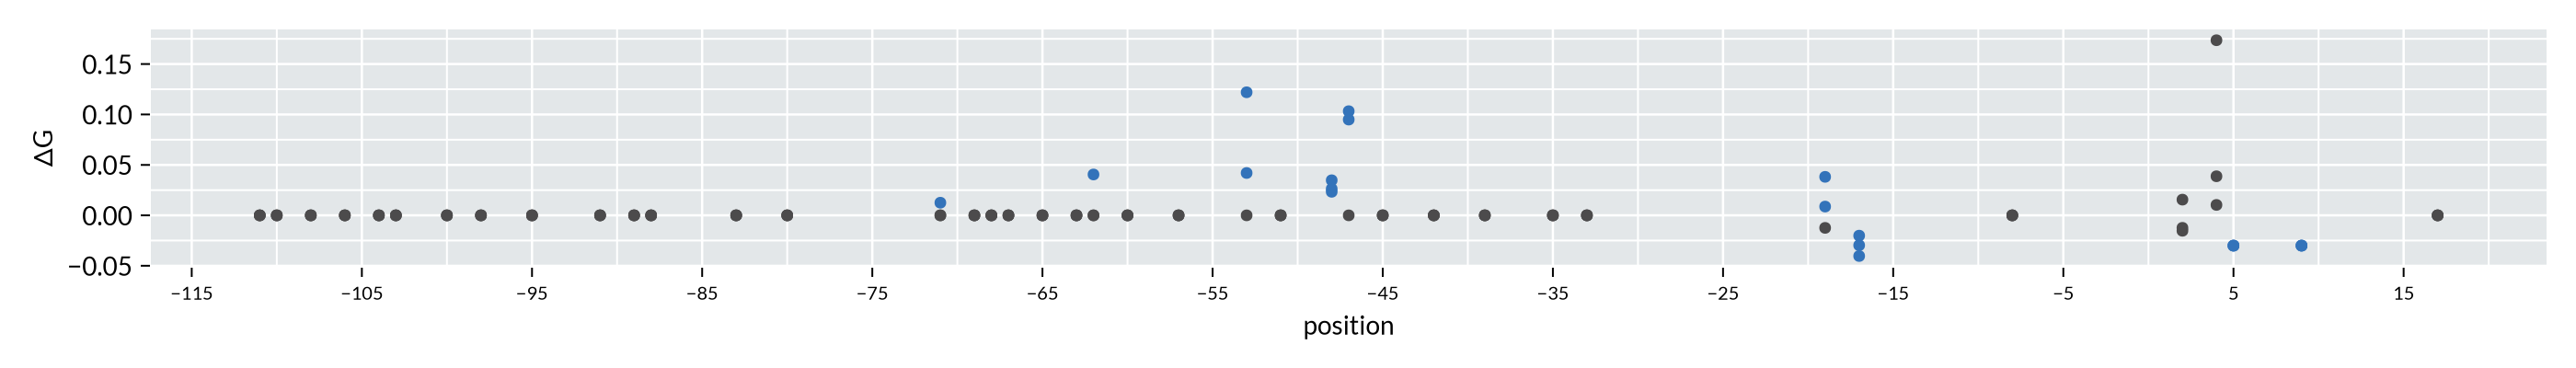

In [58]:
df_eff = eval_lagator_single_mutation("mglBp", "Glucose", true);
color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="position", ylabel="ΔG", xticklabelsize=10, xticks=collect(-115:10:45))
#xlims!(ax, -1,  483)
scatter!(ax, df_eff.pos, df_eff.brick, color=[color_dict[x] for x in (df_eff.Lagator_tss_wt .== df_eff.Lagator_tss_mut)])
    
fig

In [59]:
df_eff

Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut,promoter,source,expression_shift,growth_condition,growth_condition_info,replicate,int_base
,Int64,Int64,String,String,Float64,Int64,Int64,Int64,Int64,String,String7,Float64,String,String?,Int64,Int64
1,91,-111,A,C,0.0,3,3,0,0,mglBp,genome,-0.103239,Glucose,M9 Minimal Media with 0.5% Glucose,1,2
2,92,-111,A,G,0.0,3,3,0,0,mglBp,genome,-0.180585,Glucose,M9 Minimal Media with 0.5% Glucose,1,3
3,93,-111,A,T,0.0,3,3,0,0,mglBp,genome,-0.123285,Glucose,M9 Minimal Media with 0.5% Glucose,1,4
4,94,-110,C,A,0.0,3,3,0,0,mglBp,genome,0.151254,Glucose,M9 Minimal Media with 0.5% Glucose,1,1
5,95,-110,C,G,0.0,3,3,0,0,mglBp,genome,0.0076438,Glucose,M9 Minimal Media with 0.5% Glucose,1,3
6,96,-110,C,T,0.0,3,3,0,0,mglBp,genome,-0.0178795,Glucose,M9 Minimal Media with 0.5% Glucose,1,4
7,100,-108,C,A,0.0,3,3,0,0,mglBp,genome,0.0261323,Glucose,M9 Minimal Media with 0.5% Glucose,1,1
8,101,-108,C,G,0.0,3,3,0,0,mglBp,genome,0.0962662,Glucose,M9 Minimal Media with 0.5% Glucose,1,3
9,102,-108,C,T,0.0,3,3,0,0,mglBp,genome,0.0767679,Glucose,M9 Minimal Media with 0.5% Glucose,1,4


### ldrDp

In [12]:
x = eval_lagator_single_mutation("ldrDp", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,237,-37.0,G,T,0.143625,-41,-41,-7,-7
2,244,-34.0,C,A,0.0596254,-41,-41,-7,-7
3,248,-33.0,T,C,0.0555271,-41,-41,-7,-7
4,312,-12.0,G,T,0.0551961,-41,-41,-7,-7
5,250,-32.0,G,A,0.0431036,-41,-41,-7,-7
6,291,-19.0,A,T,0.0364831,-41,-41,-7,-1
7,299,-16.0,C,G,0.0347905,-41,-41,-7,-7
8,322,-8.0,C,A,0.0290328,-41,-41,-7,-9
9,252,-32.0,G,T,0.0244386,-41,-41,-7,-7


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,ldrDp,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-96,4,A
2,ldrDp,T,genome,0.568104,Glucose,M9 Minimal Media with 0.5% Glucose,1,-37,4,G
3,ldrDp,C,genome,0.563129,Glucose,M9 Minimal Media with 0.5% Glucose,1,-23,2,A
4,ldrDp,T,genome,0.479835,Glucose,M9 Minimal Media with 0.5% Glucose,1,-58,4,C
5,ldrDp,C,genome,0.464512,Glucose,M9 Minimal Media with 0.5% Glucose,1,5,2,G
6,ldrDp,A,genome,-0.443437,Glucose,M9 Minimal Media with 0.5% Glucose,1,35,1,G
7,ldrDp,A,genome,-0.408253,Glucose,M9 Minimal Media with 0.5% Glucose,1,-91,1,T
8,ldrDp,G,genome,0.405395,Glucose,M9 Minimal Media with 0.5% Glucose,1,-17,3,T
9,ldrDp,G,genome,0.404734,Glucose,M9 Minimal Media with 0.5% Glucose,1,-75,3,T


LoadError: ArgumentError: column name :same_TSS not found in the data frame

In [13]:
x = eval_lagator_single_mutation("ldrDp", "Glucose", true);

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,237,-63.0,G,T,0.143625,-41,-41,-9,-9
2,60,-122.0,A,T,0.0793153,-41,-123,-9,-61
3,244,-60.0,C,A,0.0596254,-41,-41,-9,-9
4,248,-59.0,T,C,0.0555271,-41,-41,-9,-9
5,312,-38.0,G,T,0.0551961,-41,-41,-9,-9
6,250,-58.0,G,A,0.0431036,-41,-41,-9,-9
7,291,-45.0,A,T,0.0364831,-41,-41,-9,-67
8,299,-42.0,C,G,0.0347905,-41,-41,-9,-9
9,322,-34.0,C,A,0.0290328,-41,-41,-9,-9


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,ldrDp,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-96,4,A
2,ldrDp,T,genome,0.568104,Glucose,M9 Minimal Media with 0.5% Glucose,1,-37,4,G
3,ldrDp,C,genome,0.563129,Glucose,M9 Minimal Media with 0.5% Glucose,1,-23,2,A
4,ldrDp,T,genome,0.479835,Glucose,M9 Minimal Media with 0.5% Glucose,1,-58,4,C
5,ldrDp,C,genome,0.464512,Glucose,M9 Minimal Media with 0.5% Glucose,1,5,2,G
6,ldrDp,A,genome,-0.443437,Glucose,M9 Minimal Media with 0.5% Glucose,1,35,1,G
7,ldrDp,A,genome,-0.408253,Glucose,M9 Minimal Media with 0.5% Glucose,1,-91,1,T
8,ldrDp,G,genome,0.405395,Glucose,M9 Minimal Media with 0.5% Glucose,1,-17,3,T
9,ldrDp,G,genome,0.404734,Glucose,M9 Minimal Media with 0.5% Glucose,1,-75,3,T


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### ghoSp

In [14]:
x = eval_lagator_single_mutation("ghoSp", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,217,-43.0,C,A,0.177653,6,-71,3,3
2,462,38.0,A,T,0.150753,6,6,3,3
3,148,-66.0,T,A,0.112853,6,-94,3,3
4,384,12.0,T,G,0.0765205,6,6,3,3
5,369,7.0,G,T,0.0727356,6,3,3,25
6,372,8.0,C,T,0.0713161,6,3,3,25
7,457,37.0,G,A,0.0712751,6,6,3,3
8,454,36.0,G,A,0.0703069,6,6,3,3
9,314,-11.0,A,G,0.0664303,6,-17,3,25


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,ghoSp,A,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-43,1,C
2,ghoSp,T,genome,0.615374,Glucose,M9 Minimal Media with 0.5% Glucose,1,-20,4,G
3,ghoSp,A,genome,0.567422,Glucose,M9 Minimal Media with 0.5% Glucose,1,-82,1,T
4,ghoSp,T,genome,0.492992,Glucose,M9 Minimal Media with 0.5% Glucose,1,-4,4,G
5,ghoSp,A,genome,0.440343,Glucose,M9 Minimal Media with 0.5% Glucose,1,-91,1,G
6,ghoSp,T,genome,0.431579,Glucose,M9 Minimal Media with 0.5% Glucose,1,-49,4,G
7,ghoSp,A,genome,0.422155,Glucose,M9 Minimal Media with 0.5% Glucose,1,-108,1,G
8,ghoSp,T,genome,0.374796,Glucose,M9 Minimal Media with 0.5% Glucose,1,-34,4,G
9,ghoSp,A,genome,0.34874,Glucose,M9 Minimal Media with 0.5% Glucose,1,-18,1,G


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### araBp

In [15]:
x = eval_lagator_single_mutation("araBp", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,94,-84.0,T,A,0.155299,-112,-112,6,6
2,231,-39.0,C,T,0.0771726,-112,-42,6,6
3,100,-82.0,G,A,0.0726083,-112,-112,6,6
4,298,-16.0,C,A,0.0681256,-112,-44,6,6
5,84,-88.0,C,T,0.0551805,-112,-112,6,6
6,32,-105.0,T,C,0.0521456,-112,-112,6,6
7,115,-77.0,G,A,0.0331882,-112,-105,6,6
8,103,-81.0,C,A,0.0302879,-112,-112,6,6
9,78,-90.0,C,T,0.0296887,-112,-112,6,6


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,araBp,A,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-77,1,G
2,araBp,C,genome,0.608583,Glucose,M9 Minimal Media with 0.5% Glucose,1,25,2,G
3,araBp,A,genome,0.463968,Glucose,M9 Minimal Media with 0.5% Glucose,1,39,1,T
4,araBp,A,genome,0.423433,Glucose,M9 Minimal Media with 0.5% Glucose,1,40,1,T
5,araBp,G,genome,0.373249,Glucose,M9 Minimal Media with 0.5% Glucose,1,-108,3,T
6,araBp,G,genome,0.339219,Glucose,M9 Minimal Media with 0.5% Glucose,1,-21,3,A
7,araBp,C,genome,-0.290468,Glucose,M9 Minimal Media with 0.5% Glucose,1,-19,2,T
8,araBp,A,genome,0.286795,Glucose,M9 Minimal Media with 0.5% Glucose,1,-28,1,T
9,araBp,G,genome,0.285557,Glucose,M9 Minimal Media with 0.5% Glucose,1,-9,3,T


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### cpxRp2

In [16]:
x = eval_lagator_single_mutation("cpxRp2", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,129,-73.0,A,T,0.0938645,-40,-100,2,2
2,243,-35.0,G,T,0.0858197,-40,-40,2,-42
3,319,-9.0,T,A,0.0827563,-40,-40,2,2
4,316,-10.0,T,A,0.0610141,-40,-40,2,2
5,117,-77.0,C,T,0.0594247,-40,-81,2,2
6,251,-32.0,T,C,0.0528081,-40,-40,2,2
7,320,-9.0,T,C,0.0502625,-40,-40,2,2
8,300,-16.0,A,T,0.0497494,-40,-40,2,2
9,201,-49.0,C,T,0.0485143,-40,-81,2,2


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,cpxRp2,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-77,4,C
2,cpxRp2,A,genome,0.886121,Glucose,M9 Minimal Media with 0.5% Glucose,1,31,1,T
3,cpxRp2,G,genome,0.522044,Glucose,M9 Minimal Media with 0.5% Glucose,1,9,3,T
4,cpxRp2,A,genome,0.398198,Glucose,M9 Minimal Media with 0.5% Glucose,1,-9,1,T
5,cpxRp2,T,genome,0.396643,Glucose,M9 Minimal Media with 0.5% Glucose,1,-49,4,C
6,cpxRp2,C,genome,0.368412,Glucose,M9 Minimal Media with 0.5% Glucose,1,11,2,A
7,cpxRp2,A,genome,0.35587,Glucose,M9 Minimal Media with 0.5% Glucose,1,-27,1,G
8,cpxRp2,A,genome,0.337287,Glucose,M9 Minimal Media with 0.5% Glucose,1,36,1,G
9,cpxRp2,G,genome,0.291306,Glucose,M9 Minimal Media with 0.5% Glucose,1,25,3,T


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### mhpRp1

In [17]:
x = eval_lagator_single_mutation("mhpRp1", "Spermidine");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,314,-11.0,A,G,0.206358,-17,-17,25,25
2,370,8.0,T,A,0.133881,-17,-20,25,25
3,315,-11.0,A,T,0.114954,-17,-17,25,25
4,373,9.0,T,A,0.0911423,-17,-19,25,25
5,388,14.0,G,A,0.0750158,-17,-17,25,25
6,307,-13.0,T,A,0.0625159,-17,-20,25,25
7,435,29.0,G,T,0.0620193,-17,-3,25,25
8,385,13.0,T,A,0.0614008,-17,-17,25,3
9,319,-9.0,A,C,0.0609962,-17,-17,25,25


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,mhpRp1,A,genome,1.0,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,8,1,T
2,mhpRp1,G,genome,0.874462,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,-11,3,A
3,mhpRp1,G,genome,0.752316,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,-113,3,T
4,mhpRp1,C,genome,0.489044,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,-9,2,A
5,mhpRp1,T,genome,0.476097,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,-65,4,C
6,mhpRp1,G,genome,0.471031,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,-111,3,A
7,mhpRp1,C,genome,0.46947,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,18,2,G
8,mhpRp1,G,genome,0.45676,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,-51,3,A
9,mhpRp1,A,genome,0.455359,Spermidine,"M9 Minimal Media with 0.5% Glucose to steady state, then induction with 5mM spermidine for 1h.",1,-17,1,T


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### rcsBp1

In [18]:
x = eval_lagator_single_mutation("rcsBp1", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,234,-38.0,A,T,0.166007,-42,-42,-3,11
2,310,-12.0,G,A,0.0801153,-42,-42,-3,11
3,244,-34.0,A,C,0.0660397,-42,-42,-3,-20
4,246,-34.0,A,T,0.0466792,-42,-37,-3,-3
5,288,-20.0,A,T,0.0378036,-42,-42,-3,-3
6,294,-18.0,G,T,0.0368968,-42,-42,-3,-3
7,252,-32.0,G,T,0.0358104,-42,-42,-3,-3
8,296,-17.0,A,G,0.032543,-42,-42,-3,-3
9,226,-40.0,C,A,0.0253644,-42,-42,-3,-3


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,rcsBp1,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-38,4,A
2,rcsBp1,T,genome,0.914773,Glucose,M9 Minimal Media with 0.5% Glucose,1,-113,4,A
3,rcsBp1,A,genome,0.848705,Glucose,M9 Minimal Media with 0.5% Glucose,1,13,1,C
4,rcsBp1,C,genome,0.79374,Glucose,M9 Minimal Media with 0.5% Glucose,1,-34,2,A
5,rcsBp1,T,genome,0.753644,Glucose,M9 Minimal Media with 0.5% Glucose,1,-55,4,A
6,rcsBp1,T,genome,0.653048,Glucose,M9 Minimal Media with 0.5% Glucose,1,9,4,C
7,rcsBp1,T,genome,0.64382,Glucose,M9 Minimal Media with 0.5% Glucose,1,-40,4,C
8,rcsBp1,T,genome,0.614235,Glucose,M9 Minimal Media with 0.5% Glucose,1,-103,4,G
9,rcsBp1,T,genome,0.572064,Glucose,M9 Minimal Media with 0.5% Glucose,1,-62,4,G


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### tolCp1

In [19]:
x = eval_lagator_single_mutation("tolCp1", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,228,-40.0,C,T,0.204662,-44,-44,-5,-5
2,307,-13.0,T,A,0.0913982,-44,-44,-5,-7
3,235,-37.0,C,A,0.0626272,-44,-44,-5,-5
4,308,-13.0,T,C,0.0555112,-44,-44,-5,-5
5,227,-40.0,C,G,0.0463299,-44,-44,-5,-5
6,303,-15.0,A,T,0.0459424,-44,-44,-5,-5
7,241,-35.0,G,A,0.0452736,-44,-44,-5,-5
8,226,-40.0,C,A,0.0308372,-44,-44,-5,-5
9,243,-35.0,G,T,0.025669,-44,-44,-5,-5


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,tolCp1,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-40,4,C
2,tolCp1,G,genome,0.261183,Glucose,M9 Minimal Media with 0.5% Glucose,1,-37,3,C
3,tolCp1,A,genome,0.249222,Glucose,M9 Minimal Media with 0.5% Glucose,1,8,1,T
4,tolCp1,C,genome,0.243688,Glucose,M9 Minimal Media with 0.5% Glucose,1,-61,2,G
5,tolCp1,T,genome,0.208836,Glucose,M9 Minimal Media with 0.5% Glucose,1,25,4,C
6,tolCp1,A,genome,0.207995,Glucose,M9 Minimal Media with 0.5% Glucose,1,40,1,C
7,tolCp1,T,genome,0.207789,Glucose,M9 Minimal Media with 0.5% Glucose,1,-15,4,A
8,tolCp1,G,genome,0.20675,Glucose,M9 Minimal Media with 0.5% Glucose,1,-115,3,C
9,tolCp1,T,genome,0.206454,Glucose,M9 Minimal Media with 0.5% Glucose,1,-78,4,C


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### tolCp3

In [20]:
x = eval_lagator_single_mutation("tolCp3", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,54,-98.0,C,T,0.204662,-102,-102,2,2
2,133,-71.0,T,A,0.0913982,-102,-102,2,2
3,61,-95.0,C,A,0.0626272,-102,-102,2,2
4,134,-71.0,T,C,0.0555112,-102,-102,2,2
5,53,-98.0,C,G,0.0463299,-102,-102,2,2
6,129,-73.0,A,T,0.0459424,-102,-102,2,2
7,67,-93.0,G,A,0.0452736,-102,-102,2,2
8,345,-1.0,A,T,0.0426823,-102,-28,2,2
9,385,13.0,T,A,0.031018,-102,-15,2,2


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,tolCp3,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-98,4,C
2,tolCp3,T,genome,0.569879,Glucose,M9 Minimal Media with 0.5% Glucose,1,-1,4,A
3,tolCp3,T,genome,0.528785,Glucose,M9 Minimal Media with 0.5% Glucose,1,-9,4,G
4,tolCp3,G,genome,0.403337,Glucose,M9 Minimal Media with 0.5% Glucose,1,-95,3,C
5,tolCp3,A,genome,0.389026,Glucose,M9 Minimal Media with 0.5% Glucose,1,13,1,T
6,tolCp3,G,genome,0.351054,Glucose,M9 Minimal Media with 0.5% Glucose,1,5,3,T
7,tolCp3,G,genome,0.338716,Glucose,M9 Minimal Media with 0.5% Glucose,1,7,3,T
8,tolCp3,A,genome,0.325631,Glucose,M9 Minimal Media with 0.5% Glucose,1,-32,1,T
9,tolCp3,A,genome,0.322005,Glucose,M9 Minimal Media with 0.5% Glucose,1,34,1,T


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### xylAp

In [21]:
x = eval_lagator_single_mutation("xylAp", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,202,-48.0,G,A,0.234356,-39,-76,-32,-32
2,312,-12.0,A,T,0.1766,-39,-39,-32,-32
3,309,-13.0,C,T,0.129929,-39,-40,-32,-32
4,155,-64.0,A,G,0.114439,-39,-71,-32,-32
5,147,-67.0,A,T,0.111371,-39,-71,-32,-32
6,144,-68.0,A,T,0.0995583,-39,-95,-32,1
7,322,-8.0,T,A,0.0800005,-39,-39,-32,-32
8,136,-70.0,T,A,0.079032,-39,-76,-32,-36
9,251,-32.0,G,C,0.0742694,-39,-39,-32,1


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,xylAp,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-68,4,A
2,xylAp,T,genome,0.656106,Glucose,M9 Minimal Media with 0.5% Glucose,1,-15,4,C
3,xylAp,T,genome,0.643899,Glucose,M9 Minimal Media with 0.5% Glucose,1,-13,4,C
4,xylAp,A,genome,0.624015,Glucose,M9 Minimal Media with 0.5% Glucose,1,-48,1,G
5,xylAp,G,genome,0.399884,Glucose,M9 Minimal Media with 0.5% Glucose,1,-51,3,T
6,xylAp,T,genome,0.382344,Glucose,M9 Minimal Media with 0.5% Glucose,1,-41,4,C
7,xylAp,G,genome,0.342643,Glucose,M9 Minimal Media with 0.5% Glucose,1,37,3,C
8,xylAp,A,genome,0.33594,Glucose,M9 Minimal Media with 0.5% Glucose,1,-115,1,C
9,xylAp,G,genome,0.330663,Glucose,M9 Minimal Media with 0.5% Glucose,1,-104,3,A


LoadError: ArgumentError: column name :same_TSS not found in the data frame

### xylFp

In [22]:
x = eval_lagator_single_mutation("xylFp", "Glucose");

color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="base", ylabel="ΔG", xticks=(2:15:480, string.(collect(-115:5:44))), xticklabelsize=10)
xlims!(ax, -1,  483)
scatter!(ax, x.index, x.brick, color=[color_dict[x] for x in x.same_TSS])
    
fig

Top 10 single mutations: 


Row,index,pos,wt_base,mut_base,brick,Lagator_tss_wt,Lagator_tss_mut,lafleur_tss_wt,lafleur_tss_mut
,Int64,Float64,Char,Char,Float64,Int64,Int64,Int64,Int64
1,312,-12.0,A,T,0.180132,-39,-39,3,12
2,324,-8.0,A,T,0.136187,-39,-40,3,3
3,250,-32.0,T,A,0.0834204,-39,-39,3,3
4,315,-11.0,A,T,0.0708323,-39,-38,3,3
5,460,38.0,C,A,0.0568589,-39,10,3,3
6,254,-31.0,T,C,0.0520706,-39,-39,3,3
7,441,31.0,C,T,0.0493857,-39,-1,3,3
8,298,-16.0,T,A,0.0488233,-39,-39,3,3
9,318,-10.0,A,T,0.0410175,-39,-39,3,3


Highest observed expression shift: 


Row,promoter,base,source,expression_shift,growth_condition,growth_condition_info,replicate,pos,int_base,wt_base
,String,Char,String7,Float64,String,String?,Int64,Int64,Int64,String1
1,xylFp,T,genome,1.0,Glucose,M9 Minimal Media with 0.5% Glucose,1,-25,4,C
2,xylFp,A,genome,0.693418,Glucose,M9 Minimal Media with 0.5% Glucose,1,23,1,T
3,xylFp,T,genome,0.684505,Glucose,M9 Minimal Media with 0.5% Glucose,1,-106,4,A
4,xylFp,T,genome,0.576252,Glucose,M9 Minimal Media with 0.5% Glucose,1,-53,4,A
5,xylFp,T,genome,0.559384,Glucose,M9 Minimal Media with 0.5% Glucose,1,-96,4,G
6,xylFp,C,genome,0.559077,Glucose,M9 Minimal Media with 0.5% Glucose,1,2,2,T
7,xylFp,G,genome,0.547015,Glucose,M9 Minimal Media with 0.5% Glucose,1,30,3,A
8,xylFp,T,genome,0.522203,Glucose,M9 Minimal Media with 0.5% Glucose,1,0,4,C
9,xylFp,T,genome,0.509252,Glucose,M9 Minimal Media with 0.5% Glucose,1,-8,4,A


LoadError: ArgumentError: column name :same_TSS not found in the data frame

#### rspAp

Top 10 single mutations: 
Lagator promoter: -46
LaFleur TSS: -1
Highest observed expression shift: 


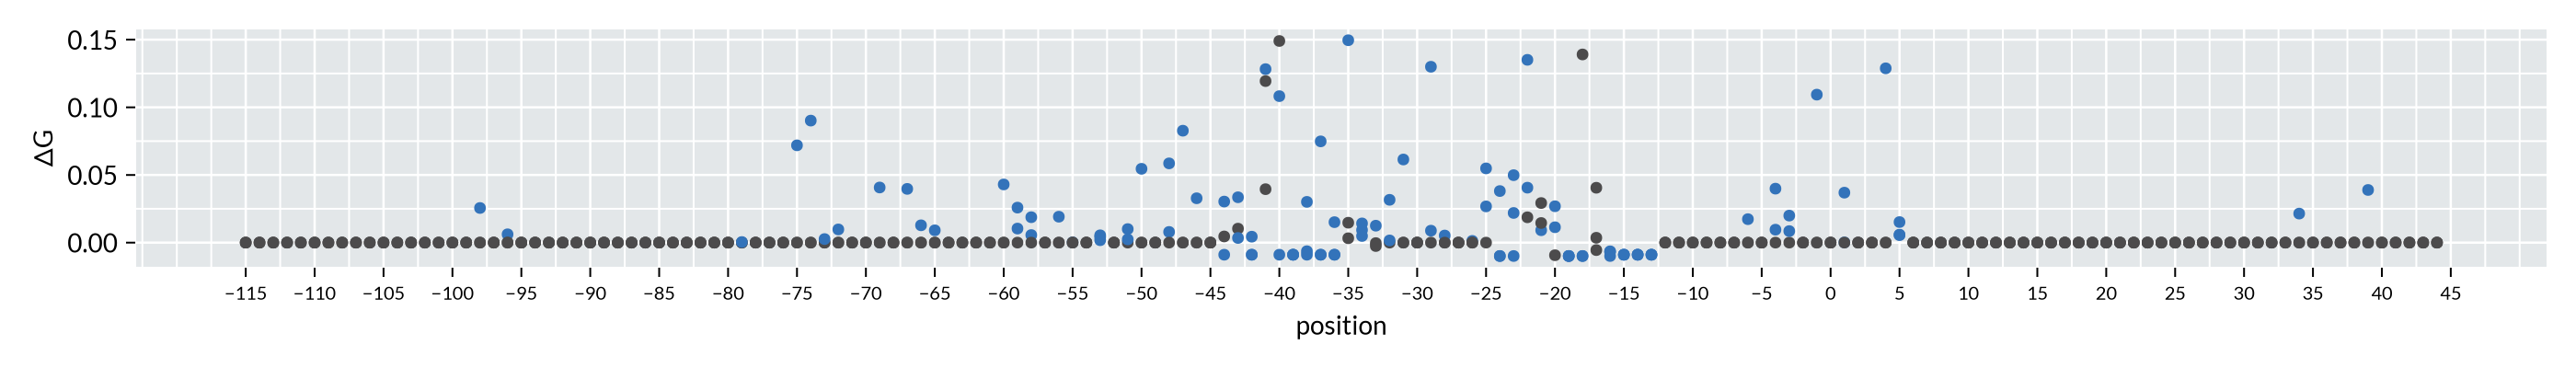

In [62]:
df_eff = eval_lagator_single_mutation("tabA_predicted", "Gentamycin");
color_dict = Dict(
    1=> palette[1],
    0=> palette[2]
)

fig = Figure(size=(1400, 200))
ax = Axis(fig[1, 1], xlabel="position", ylabel="ΔG", xticklabelsize=10, xticks=collect(-115:5:45))
#xlims!(ax, -1,  483)
scatter!(ax, df_eff.pos, df_eff.brick, color=[color_dict[x] for x in (df_eff.Lagator_tss_wt .== df_eff.Lagator_tss_mut)])
    
fig

Now test out double mutations

In [28]:
def create_double_mutations(sequence):
    """Create all possible double mutations for a given sequence
    and return them as an arry of integers."""
    
    num_seq_dict = dict(A=0, C=1, G=2, T=3)
    mutant_list = [[num_seq_dict[x] for x in list(sequence)]]
    mutations = [('N', 'N')]
    for i in range(159):
        for j in range(i+1, 160):
            base1 = sequence[i]
            base2 = sequence[j]
            for b in filter(lambda x: x != base1, ['A', 'C', 'G', 'T']):
                new_sequence = list(deepcopy(sequence))
                new_sequence[i] = b
                for bb in filter(lambda x: x != base2, ['A', 'C', 'G', 'T']):
                    new_new_sequence = list(deepcopy(new_sequence))
                    new_new_sequence[j] = bb
                    mutant_list.append([num_seq_dict[x] for x in list(new_new_sequence)])
                    mutations.append(((i, sequence[i], b), (j, sequence[j], bb)))
    return np.array(mutant_list, dtype=np.int8), mutations

In [29]:
seq = df.loc[df.promoter == 'araBp', 'sequence'].values[0]
mut_list, mutations = create_double_mutations(seq)

In [30]:
treatAs = "36N"
bricks = [np.exp((-getBrickDict({treatAs: np.array([x])}, theModel)[treatAs][0])* 0.04)  for x in mut_list]
max_bricks = [np.max(brick) for brick in bricks]
len(max_bricks)

114481

In [31]:
ordered_mutations = np.flip(np.argsort(max_bricks))
for i in range(25):
    ind = ordered_mutations[i]
    print(np.floor((ind - 1)/3), mutations[ind], max_bricks[ind])

27770.0 ((76, 'C', 'T'), (99, 'C', 'A')) 1.075937424131759
13395.0 ((31, 'T', 'A'), (33, 'G', 'A')) 1.0518910983213725
11837.0 ((27, 'C', 'T'), (31, 'T', 'A')) 1.0317128875251043
4696.0 ((10, 'T', 'C'), (31, 'T', 'A')) 1.028199051708909
13398.0 ((31, 'T', 'A'), (34, 'C', 'A')) 1.0028917461632385
11042.0 ((25, 'C', 'T'), (31, 'T', 'A')) 1.0021980898633593
12229.0 ((28, 'A', 'G'), (31, 'T', 'A')) 1.0019721664708412
1968.0 ((4, 'C', 'A'), (31, 'T', 'A')) 0.9944394843770012
11836.0 ((27, 'C', 'G'), (31, 'T', 'A')) 0.9920277724216591
1970.0 ((4, 'C', 'T'), (31, 'T', 'A')) 0.989657281082448
5139.0 ((11, 'T', 'A'), (31, 'T', 'A')) 0.9875761814899636
5582.0 ((12, 'A', 'T'), (31, 'T', 'A')) 0.9847597110957697
1969.0 ((4, 'C', 'G'), (31, 'T', 'A')) 0.9836558800834718
12230.0 ((28, 'A', 'T'), (31, 'T', 'A')) 0.9829538130372046
2430.0 ((5, 'A', 'C'), (31, 'T', 'A')) 0.9811792125089838
13395.0 ((31, 'T', 'A'), (33, 'G', 'T')) 0.981172069550317
12619.0 ((29, 'C', 'G'), (31, 'T', 'A')) 0.980022348606